## **Prepare environment, load and prepare data**

Required environment

*  Python 3.12.12
*  numpy: 2.0.2
*  pandas: 2.2.2
*  seaborn: 0.13.2
*  matplotlib: 3.10.0










In [1]:
!python --version

Python 3.12.12


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("pandas:",pd.__version__)
print("numpy:",np.__version__)
print("seaborn:",sns.__version__)
print("matplotlib:",plt.matplotlib.__version__)

pandas: 2.2.2
numpy: 2.0.2
seaborn: 0.13.2
matplotlib: 3.10.0


In [3]:
# import dataset

df = pd.read_csv('https://data.ontario.ca/dataset/1f14addd-e4fc-4a07-9982-ad98db07ef86/resource/4cc07c1b-62ed-4ece-a2a4-d05d0f45081c/download/img-wage-rate-by-edu-age-sex-ft-pt-ca-on-2006-24.csv')

In [4]:
# Rename the ' Men' column to 'Men Wage' and ' Women' to 'Women Wage' to remove
# leading space and add clarity
df_renamed = df.rename(columns={' Men': 'Men_Wage', ' Women': 'Women_Wage'})

# Display the first few rows to show the renamed columns
display(df_renamed.head())

,YEAR,GEOGRAPHY,IMMIGRANT,TYPE OF WORK,WAGE RATE,EDUCATION,AGE GROUP,Both sexes,Men_Wage,Women_Wage
0,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",15 +,17.5,19.2,16.0
1,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 +,19.4,21.5,17.5
2,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 - 34,18.0,19.0,16.8
3,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 - 54,19.5,21.5,17.8
4,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 - 64,19.5,21.5,17.6


In [5]:
# change "0.0" in dataset to NaN and flag as suppressed
for col in ['Men_Wage', 'Women_Wage']:
    # Create a new column to flag suppressed values for each gender
    df_renamed[f'{col}_is_suppressed'] = df_renamed[col].astype(str).str.strip() == "0.0"
    # Replace "0.0" strings with np.nan
    df_renamed[col] = df_renamed[col].replace('0.0', np.nan)

# Display the first few rows to show the new columns and replaced values
display(df_renamed.head())

,YEAR,GEOGRAPHY,IMMIGRANT,TYPE OF WORK,WAGE RATE,EDUCATION,AGE GROUP,Both sexes,Men_Wage,Women_Wage,Men_Wage_is_suppressed,Women_Wage_is_suppressed
0,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",15 +,17.5,19.2,16.0,False,False
1,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 +,19.4,21.5,17.5,False,False
2,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 - 34,18.0,19.0,16.8,False,False
3,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 - 54,19.5,21.5,17.8,False,False
4,2006,Canada,Total,All employees,Median hourly wage,"Total, all education levels",25 - 64,19.5,21.5,17.6,False,False


In [6]:
# Filter for Ontario
df_ontario = df_renamed[df_renamed['GEOGRAPHY'] == ' Ontario']


# **Research Question 2**

Examine wage trends across male and female groups to determine whether the gap is narrowing.

Method: Apply a linear regression to see wage ~ year X gender and using K-Fold Cross-Validation to validate regression model.

In [7]:
# 1. Create a new DataFrame df_melted with 'YEAR', 'Men_Wage', and 'Women_Wage'
df_melted = df_ontario[['YEAR', 'Men_Wage', 'Women_Wage']].copy()

# 2. Use the melt() method to unpivot the DataFrame
df_melted = df_melted.melt(
    id_vars=['YEAR'],
    value_vars=['Men_Wage', 'Women_Wage'],
    var_name='Gender',
    value_name='Wage'
)

# 3. Clean the 'Gender' column
df_melted['Gender'] = df_melted['Gender'].replace({'Men_Wage': 'Men', 'Women_Wage': 'Women'})

# 4. Convert the 'Wage' column to a numeric data type, handling non-convertible values
df_melted['Wage'] = pd.to_numeric(df_melted['Wage'], errors='coerce')

# 5. Filter out rows where the 'Wage' column has NaN values
df_disaggregated = df_melted.dropna(subset=['Wage'])

# Display the first few rows of the disaggregated DataFrame
print("Disaggregated DataFrame head:")
display(df_disaggregated.head())

# Display basic info to confirm data types and non-null counts
print("\nDisaggregated DataFrame Info:")
df_disaggregated.info()

Disaggregated DataFrame head:


,YEAR,Gender,Wage
0,2006,Men,20.0
1,2006,Men,22.0
2,2006,Men,19.5
3,2006,Men,22.1
4,2006,Men,22.1



Disaggregated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41040 entries, 0 to 41039
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    41040 non-null  int64  
 1   Gender  41040 non-null  object 
 2   Wage    41040 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 962.0+ KB


In [8]:
# Encode the 'Gender' column into a numerical format
df_disaggregated['Gender_encoded'] = df_disaggregated['Gender'].apply(lambda x: 1 if x == 'Men' else 0)

# Display the first few rows to show the new encoded column
print("Disaggregated DataFrame with encoded Gender head:")
display(df_disaggregated.head())

# Display basic info to confirm the new column and data types
print("\nDisaggregated DataFrame Info with encoded Gender:")
df_disaggregated.info()

Disaggregated DataFrame with encoded Gender head:


,YEAR,Gender,Wage,Gender_encoded
0,2006,Men,20.0,1
1,2006,Men,22.0,1
2,2006,Men,19.5,1
3,2006,Men,22.1,1
4,2006,Men,22.1,1



Disaggregated DataFrame Info with encoded Gender:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41040 entries, 0 to 41039
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            41040 non-null  int64  
 1   Gender          41040 non-null  object 
 2   Wage            41040 non-null  float64
 3   Gender_encoded  41040 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.3+ MB


In [9]:
import statsmodels.formula.api as smf

# Define the linear regression model formula
# Wage is the dependent variable
# YEAR, Gender_encoded, and their interaction are independent variables
formula = 'Wage ~ YEAR + Gender_encoded + YEAR:Gender_encoded'

# Fit the OLS (Ordinary Least Squares) model
model_disaggregated = smf.ols(formula=formula, data=df_disaggregated).fit()

# Print the regression summary
print(model_disaggregated.summary())


                            OLS Regression Results                            
Dep. Variable:                   Wage   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     714.0
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:24:33   Log-Likelihood:            -1.5673e+05
No. Observations:               41040   AIC:                         3.135e+05
Df Residuals:                   41036   BIC:                         3.135e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -735.4728    

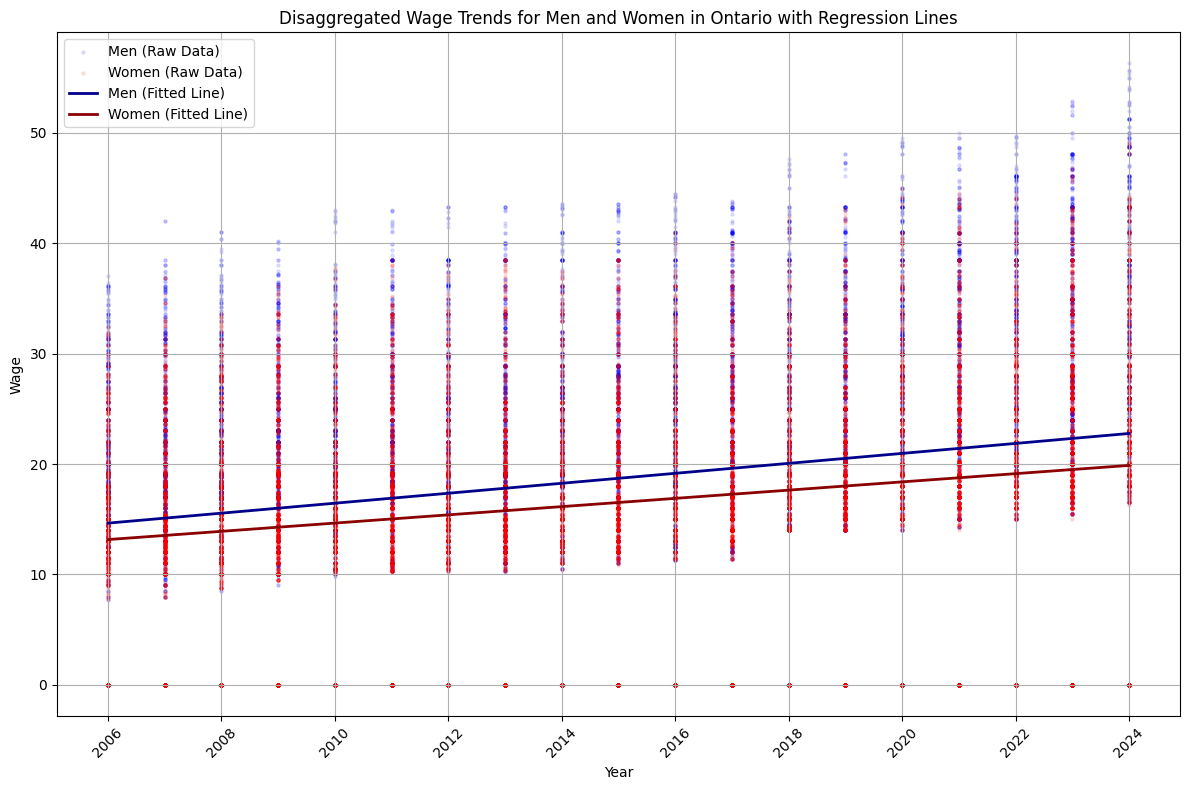

In [10]:
# Extract coefficients from the fitted model
intercept = model_disaggregated.params['Intercept']
coef_year = model_disaggregated.params['YEAR']
coef_gender = model_disaggregated.params['Gender_encoded']
coef_year_gender_interaction = model_disaggregated.params['YEAR:Gender_encoded']

# Get unique years for plotting trend lines
years = sorted(df_disaggregated['YEAR'].unique())

# Calculate predicted wages for Men (Gender_encoded = 1)
predicted_wage_men = intercept + (coef_year * np.array(years)) + \
                     (coef_gender * 1) + (coef_year_gender_interaction * np.array(years) * 1)

# Calculate predicted wages for Women (Gender_encoded = 0)
predicted_wage_women = intercept + (coef_year * np.array(years)) + \
                       (coef_gender * 0) + (coef_year_gender_interaction * np.array(years) * 0)

plt.figure(figsize=(12, 8))

# Plot raw data points for Men
plt.scatter(df_disaggregated[df_disaggregated['Gender'] == 'Men']['YEAR'],
            df_disaggregated[df_disaggregated['Gender'] == 'Men']['Wage'],
            alpha=0.1, label='Men (Raw Data)', color='blue', s=5)

# Plot raw data points for Women
plt.scatter(df_disaggregated[df_disaggregated['Gender'] == 'Women']['YEAR'],
            df_disaggregated[df_disaggregated['Gender'] == 'Women']['Wage'],
            alpha=0.1, label='Women (Raw Data)', color='red', s=5)

# Plot fitted regression line for Men
plt.plot(years, predicted_wage_men, color='darkblue', linewidth=2, label='Men (Fitted Line)')

# Plot fitted regression line for Women
plt.plot(years, predicted_wage_women, color='darkred', linewidth=2, label='Women (Fitted Line)')

plt.xlabel('Year')
plt.ylabel('Wage')
plt.title('Disaggregated Wage Trends for Men and Women in Ontario with Regression Lines')
plt.xticks(np.arange(min(years), max(years) + 1, 2), rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From the disaggregated linear regression analysis, we can observe the following:

**Trends in Wages**: Both men's and women's wages show a clear upward trend over the years, indicated by the positive coefficient for `YEAR` in the regression model. The fitted lines confirm that wages are generally increasing for both genders.

**Narrowing Wage Gap:** Year ~ Gender has a positive coefficient (approximately 0.0781) and is statistically significant (p < 0.001).

The disaggregated analysis using linear regression, by modeling individual wages directly, provides a statistically significant picture (Prob (F-statistic): 0.00). It suggests that the absolute wage difference is actually increasing, as men's wages are growing faster than women's.

**Conclusion**: The disaggregated linear regression model, which accounts for individual wage trends and the interaction of year and gender, strongly suggests that **the wage gap between men and women in Ontario is widening**, as men's wages are increasing at a faster rate.



# **Validate our model using K-Fold Cross-Validation.**

**Prepare Data for Cross-Validation**

Extract the features (YEAR, Gender_encoded, and their interaction term) and the target variable (Wage) from df_disaggregated for use with scikit-learn.


In [11]:
# 1. Create a DataFrame X containing the feature columns 'YEAR' and 'Gender_encoded'
X = df_disaggregated[['YEAR', 'Gender_encoded']].copy()

# 2. Add a new column to X representing the interaction term
X['YEAR_Gender_interaction'] = X['YEAR'] * X['Gender_encoded']

# 3. Create a Series y containing the target variable 'Wage'
y = df_disaggregated['Wage']

# Display the first few rows of X and y to verify
print("Features (X) head:")
display(X.head())
print("\nTarget (y) head:")
display(y.head())

print("\nX info:")
X.info()
print("\ny info:")
y.info()


Features (X) head:


,YEAR,Gender_encoded,YEAR_Gender_interaction
0,2006,1,2006
1,2006,1,2006
2,2006,1,2006
3,2006,1,2006
4,2006,1,2006



Target (y) head:


,Wage
0,20.0
1,22.0
2,19.5
3,22.1
4,22.1



X info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41040 entries, 0 to 41039
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   YEAR                     41040 non-null  int64
 1   Gender_encoded           41040 non-null  int64
 2   YEAR_Gender_interaction  41040 non-null  int64
dtypes: int64(3)
memory usage: 962.0 KB

y info:
<class 'pandas.core.series.Series'>
RangeIndex: 41040 entries, 0 to 41039
Series name: Wage
Non-Null Count  Dtype  
--------------  -----  
41040 non-null  float64
dtypes: float64(1)
memory usage: 320.8 KB


In [12]:
# Apply Time Series Cross-Validation using sklearn.model_selection.TimeSeriesSplit and sklearn.linear_model.LinearRegression.
# For each fold, train the model, make predictions, and calculate evaluation metrics such as R-squared and Root Mean Squared Error (RMSE).

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store R-squared and RMSE scores for each fold
r2_scores = []
rmse_scores = []

# Create an instance of TimeSeriesSplit with n_splits=5
tscv = TimeSeriesSplit(n_splits=5)

# Loop through the splits generated by tscv.split(X)
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\nFold {fold+1}/")
    # Split the data into training and testing sets for features (X) and target (y)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Instantiate a LinearRegression model
    model = LinearRegression()

    # Train the model using the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate R-squared score and append to the list
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"  R-squared: {r2:.4f}")

    # Calculate Root Mean Squared Error (RMSE) and append to the list
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"  RMSE: {rmse:.4f}")

# Print the R-squared and RMSE scores for all folds
print("\n--- Evaluation Results Across Folds ---")
print(f"R-squared scores per fold: {r2_scores}")
print(f"RMSE scores per fold: {rmse_scores}")


Fold 1/
  R-squared: 0.0038
  RMSE: 11.7439

Fold 2/
  R-squared: -0.0215
  RMSE: 13.9314

Fold 3/
  R-squared: -2755.7545
  RMSE: 452.1081

Fold 4/
  R-squared: -0.0030
  RMSE: 9.6323

Fold 5/
  R-squared: -0.0249
  RMSE: 11.6919

--- Evaluation Results Across Folds ---
R-squared scores per fold: [0.0038312039600971737, -0.021538915999512742, -2755.754484864991, -0.0029915549766714733, -0.024925727510560103]
RMSE scores per fold: [np.float64(11.743915175291875), np.float64(13.931351587337945), np.float64(452.1080617315401), np.float64(9.632340120060704), np.float64(11.691852855588671)]


In [13]:
# Calculate the average R-squared and RMSE scores
average_r2 = np.mean(r2_scores)
average_rmse = np.mean(rmse_scores)

# Display the average scores
print(f"\nAverage R-squared across all folds: {average_r2:.4f}")
print(f"Average RMSE across all folds: {average_rmse:.4f}")


Average R-squared across all folds: -551.1600
Average RMSE across all folds: 99.8215


**Summary:**

*   The R-squared scores across the five folds were `[0.0038, -0.0215, -2755.7545, -0.0030, -0.0249]`. One fold exhibited an exceptionally large negative R-squared value (-2755.7545), indicating a significantly worse performance than a simple mean prediction for that specific fold.
*   The RMSE scores for the folds were `[11.7439, 13.9314, 452.1081, 9.6323, 11.6919]`. Consistent with the R-squared, one fold showed a drastically higher RMSE (452.1081) compared to the others, which generally ranged from 9 to 14.
*   The average R-squared across all folds was -551.1600, while the average RMSE was 99.8215. These averages are heavily skewed by the outlier performance in one fold, suggesting that, on average, the Linear Regression model performed very poorly on this time series data.

*   The time series CV is based on 18 yearly points, which is a very small sample size. As each fold has so few data points, the validation set may not capture meaningful patterns. A single unusual year (e.g., recession, policy change) could dominate the fold, leading to misleading performance estimates.
